In [1]:
!nvidia-smi
%matplotlib inline

Fri Jun 27 00:31:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100                    On  |   00000000:06:00.0 Off |                    0 |
| N/A   35C    P0            115W /  700W |   88833MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

%matplotlib inline

In [2]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    
    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

# Loading files

In [3]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

# Prompt Setting

In [4]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

# Llama 3.2 3B

## Loading the model

In [5]:
from huggingface_hub import login
login()

In [6]:
llama_3_2_3B = "meta-llama/Llama-3.2-3B-Instruct"
llama_3_3_70B = "meta-llama/Llama-3.3-70B-Instruct"

In [7]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(llama_3_2_3B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(llama_3_2_3B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

cuda


## Helper functions

In [8]:
def batch_generate_responses_llama(prompts, system_prompt=system_prompt,
                                  temperature=0.7, max_new_tokens=32768, batch_size=5):
    """
    批量生成Llama模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4

    返回:
        生成的回复列表，与prompts列表对应
    """
    # 设置padding token
    tokenizer.pad_token = tokenizer.eos_token

    responses = []

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
            # Llama模型使用apply_chat_template自动应用正确的模板
            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 分离输入和输出的tokens
        batch_responses = []
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):]
            response = tokenizer.decode(response_ids, skip_special_tokens=True)
            batch_responses.append(response)

        responses.extend(batch_responses)

    return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_llama(input_prompts)
  df = test_df.copy()
  df['model_response'] = output
  processed_judgments = get_judgments_from_responses(output)
  df['model_pred'] = processed_judgments

  return df

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## pilot

In [9]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [10]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"{""query"": ""When did the nuclear accident happe...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"{""query"": ""I need help picking out a professio...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,"{""query"": ""When did the apple tv 4k come out?""...",underspecified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"{""query"": ""Who sings i love rock 'n' roll?"", \...",underspecified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"{\n ""query"": ""Where does the new fallout game...",underspecified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"{""query"": ""Who is the existing prime minister?...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who played the king in game of thro...",underspecified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who plays henry tudor in the white ...",underspecified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who won the contest to design the c...",underspecified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"{""query"": ""How many daughters do George Washin...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.00      0.00      0.00         6
 underspecified       0.50      1.00      0.67         6

       accuracy                           0.50        12
      macro avg       0.25      0.50      0.33        12
   weighted avg       0.25      0.50      0.33        12



/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


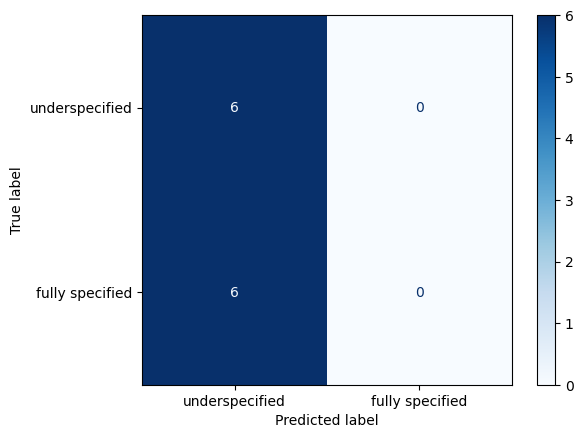

In [11]:
retrieve_results(test_df, "llama_3_2_3B_FS_UND_pilot")

## implementation

In [12]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [13]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [28:28<00:00,  7.40s/it]

Respond content: {"query": "When does braxton family values season 5 start?", "reasoning": ["The query asks for a specific date, but it lacks information about the year or any other relevant details.", "It only mentio...
Respond content: {"query": "Who did the singing for bart in the movie i can only imagine?", "reasoning": [
"The user has provided a specific song title, 'I Can Only Imagine', which suggests that they have a clear idea...
Respond content: {"query": "What episode of law and order was ludacris on?", "reasoning": [
"The query contains a specific TV show name 'Law & Order', but it lacks information about Ludacris' role, season, or any othe...
Respond content: {"query": "Who played grandpa joe in charlie and the chocolate factory?", 
"reasoning": [
"The query asks for specific information about a character named 'grandpa joe' from a movie titled 'charlie an...
Respond content: {"query": "In the dream of the rood what is the rood eventually drenched in?", "reasoning": [
"The 

,Unnamed: 0,request,gold_judgment,direct_source,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"{""query"": ""The idea that the united states was...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"{""query"": ""How many times french won the world...",underspecified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"{""query"": ""When was pink floyd's dark side of ...",underspecified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"{""query"": ""When did leonardo da vinci finish p...",underspecified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"{""query"": ""Who is the first speaker of nationa...",underspecified
...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"{""query"": ""Is Pensacola sylvestris a multicell...",underspecified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"{""query"": ""What's the leaf mass per area of La...",underspecified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"{""query"": ""When did Patsyella make its last ap...",underspecified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"{""query"": ""What's the body mass of Salamandra ...",underspecified


In [14]:
retrieve_results(test_df, "llama_3_2_3B_FS_UND")

There are unrecognized labels.


In [9]:
# Testing some missed queries

missed_queries = ["I'm in the market for a used car. How can I assess the value of a used car and what are some reliable online marketplaces?",
                  "I'm interested in classic literature. Could you create a list of must-read books from different literary periods?"]

def prepare_prompts_from_list(input_list, task_text):
    base_prompt = task_text
    complete_prompt_list = []

    for query in input_list:
        complete_prompt = base_prompt.replace("TARGET", query)
        complete_prompt_list.append(complete_prompt)

    return complete_prompt_list

miss_prompts = prepare_prompts_from_list(missed_queries, task_FS_UND)

['\nAnalyze the following input user query:\n\n{"query": "I\'m in the market for a used car. How can I assess the value of a used car and what are some reliable online marketplaces?"}\n\nPlease provide your analysis in the following JSON format:\n\n{"query": "I\'m in the market for a used car. How can I assess the value of a used car and what are some reliable online marketplaces?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}\n',
 '\nAnalyze the following input user query:\n\n{"query": "I\'m interested in classic literature. Could you create a list of must-read books from different literary periods?"}\n\nPlease provide your analysis in the following JSON format:\n\n{"query": "I\'m interested in classic literature. Could you create a list of must-read books from different literary periods?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}\n']

In [11]:
miss_responses = batch_generate_responses_llama(miss_prompts)


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


['{"query": "I\\u2019m in the market for a used car. How can I assess the value of a used car and what are some reliable online marketplaces?", \n"reasoning": [\n{\n    "@type": "Question",\n    "text": "What are some steps to assess the value of a used car?"\n},\n{\n    "@type": "Question",\n    "text": "Where are some reliable online marketplaces to buy/sell used cars?"\n}, {\n"@type":"Underspecification","description":"\nThe query lacks specificity regarding \\u00b7 The type of vehicle being sought (e.g., sedan, truck, SUV)\n\\u00b7 Specific location (city/state/country) for searching vehicles\n\\u00c2"A specific budget range for purchasing or selling\nThis makes it challenging to provide detailed guidance on assessing the value of a used car and recommending reliable online marketplaces.\n",}]}',
 '{"query": "I", \n    "reasoning": [\n      {\n        "text": "The query mentions specific topics (classic literature) but lacks clear specificity regarding time period, genre, style, or

In [12]:
print(miss_responses[0])
print(miss_responses[1])

{"query": "I\u2019m in the market for a used car. How can I assess the value of a used car and what are some reliable online marketplaces?", 
"reasoning": [
{
    "@type": "Question",
    "text": "What are some steps to assess the value of a used car?"
},
{
    "@type": "Question",
    "text": "Where are some reliable online marketplaces to buy/sell used cars?"
}, {
"@type":"Underspecification","description":"
The query lacks specificity regarding \u00b7 The type of vehicle being sought (e.g., sedan, truck, SUV)
\u00b7 Specific location (city/state/country) for searching vehicles
\u00c2"A specific budget range for purchasing or selling
This makes it challenging to provide detailed guidance on assessing the value of a used car and recommending reliable online marketplaces.
",}]}
{"query": "I", 
    "reasoning": [
      {
        "text": "The query mentions specific topics (classic literature) but lacks clear specificity regarding time period, genre, style, or other defining characterist

                 precision    recall  f1-score   support

fully specified       0.74      0.05      0.10       598
 underspecified       0.49      0.98      0.65       557

       accuracy                           0.50      1155
      macro avg       0.62      0.52      0.38      1155
   weighted avg       0.62      0.50      0.37      1155



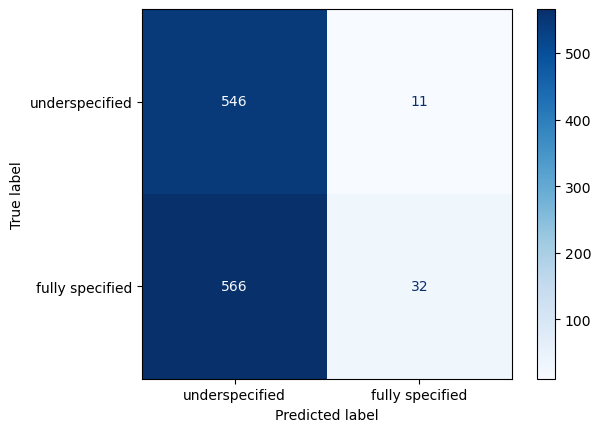

In [13]:
# If there are errors

result_df = pd.read_csv("llama_3_2_3B_FS_UND_corrected.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

                 precision    recall  f1-score   support

fully specified       0.74      0.05      0.09       431
 underspecified       0.50      0.98      0.67       424

       accuracy                           0.51       855
      macro avg       0.62      0.51      0.38       855
   weighted avg       0.62      0.51      0.37       855



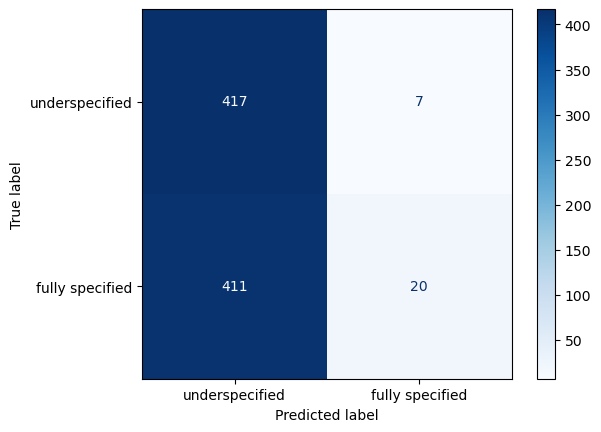

In [3]:
obtain_results_without("llama_3_2_3B_FS_UND_corrected.csv", 'AmbigQA')

# Llama 3.3 70B

## Loading the model

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
huggingface-cli login
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m sglang.launch_server --port 7501 --model-path meta-llama/Llama-3.3-70B-Instruct --tensor-parallel-size 4

"""

## Helper functions for responses in batch

In [5]:
import os
import time
from tqdm import tqdm
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor

def batch_generate_responses_llama(prompts, system_prompt=system_prompt,
                  temperature=0.7, max_tokens=32768, batch_size=5,
                  server_url="http://localhost:7501/v1",
                  model_name="meta-llama/Llama-3.3-70B-Instruct"):
    """
    批量生成使用sglang运行的Llama 3.3 70B模型的回复，使用OpenAI API风格

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        temperature: 温度参数，控制随机性，默认为0.7
        max_tokens: 生成的最大token数，默认为512
        batch_size: 并行处理的提示词数量，默认为4
        server_url: SGLang服务器URL，默认为http://localhost:30000/v1
        model_name: 模型名称，默认为meta-llama/Llama-3.3-70B-Instruct
    返回:
        生成的回复列表，与prompts列表对应
    """
    # 初始化OpenAI客户端
    client = OpenAI(
        base_url=server_url,
        api_key="None"  # SGLang不需要API key
    )

    responses = []

    # 辅助函数：处理单个提示词
    def process_prompt(prompt):
        try:
            # 创建消息格式
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]

            # 发送请求到SGLang服务器
            response = client.chat.completions.create(
                model=model_name,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
            )

            # 提取回复文本
            return response.choices[0].message.content
        except Exception as e:
            print(f"处理提示词时出错: {e}")
            return f"错误: {str(e)}"

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]

        # 使用线程池并行处理批次
        with ThreadPoolExecutor(max_workers=batch_size) as executor:
            batch_responses = list(executor.map(process_prompt, batch_prompts))

        responses.extend(batch_responses)

        # 添加短暂延迟，避免可能的速率限制
        time.sleep(0.1)

    return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_llama(input_prompts)
  df = test_df.copy()
  df['model_response'] = output
  processed_judgments = get_judgments_from_responses(output)
  df['model_pred'] = processed_judgments

  return df

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## pilot

In [11]:
test_prompts = prepare_test_prompts(df_few_shots, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 349 bytes (~87 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [12]:
test_df = run_experiment(test_prompts, df_few_shots)
test_df

100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


,request,gold_analysis,gold_thought,gold_category,gold_judgment,direct_source,model_response,model_pred
0,When did the nuclear accident happen?,"{""predicate"": ""happen"", ""argument_time"": ""when...","The predicate ""happen"" is specified; its argum...",underspecified referential/indexical argument,underspecified,CoCoNot,"{""query"": ""When did the nuclear accident happe...",underspecified
1,I need help picking out a professional wardrob...,"{""predicate"": ""provide"", ""argument_agent"": ""yo...","The predicate ""provide"" is specified; its argu...",underspecified quantified argument,underspecified,IN3,"{""query"": ""I need help picking out a professio...",underspecified
2,When did the apple tv 4k come out?,"{""predicate"": ""come out"", ""argument_time"": ""wh...","The predicate ""come out"" is underspecified bec...",underspecified predicate,underspecified,AmbigQA,Here's the analysis of the input user query:\n...,fully specified
3,Who sings i love rock 'n' roll? ...,"{""predicate"": ""sings"", ""argument_agent"": ""who""...","The predicate ""sings"" is specified; its argume...",underspecified argument concept,underspecified,AmbigQA,"{""query"": ""Who sings i love rock 'n' roll? ...",fully specified
4,Where does the new fallout game take place?,"{""predicate"": ""take place"", ""argument_location...","The predicate ""take place"" is underspecified b...",multi-sourced underspecification,underspecified,AmbigQA,"{""query"": ""Where does the new fallout game tak...",underspecified
5,Who is the existing prime minister?,"{""predicate"": ""existing prime minister"", ""argu...","The predicate ""existing prime minister"" is spe...",missing argument,underspecified,CoCoNot,"{""query"": ""Who is the existing prime minister?...",underspecified
6,Who played the king in game of thrones season 1?,"{""predicate"": ""played"", ""argument_agent"": ""who...","The predicate ""played"" is specified; its argum...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who played the king in game of thro...",fully specified
7,Who plays henry tudor in the white princess?,"{""predicate"": ""plays"", ""argument_agent"": ""who""...","The predicate ""plays"" is specified; its argume...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who plays henry tudor in the white ...",fully specified
8,Who won the contest to design the capitol buil...,"{""predicate"": ""won"", ""argument_agent"": ""who"", ...","The predicate ""won"" is specified; its argument...",fully specified request,fully specified,AmbigQA,"{""query"": ""Who won the contest to design the c...",fully specified
9,How many daughters do George Washington have?,"{""predicate: ""have"", ""argument_theme"": ""how ma...","The predicate ""have"" is specified; its argumen...",fully specified request,fully specified,IN3,"{""query"": ""How many daughters do George Washin...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.71      0.83      0.77         6
 underspecified       0.80      0.67      0.73         6

       accuracy                           0.75        12
      macro avg       0.76      0.75      0.75        12
   weighted avg       0.76      0.75      0.75        12



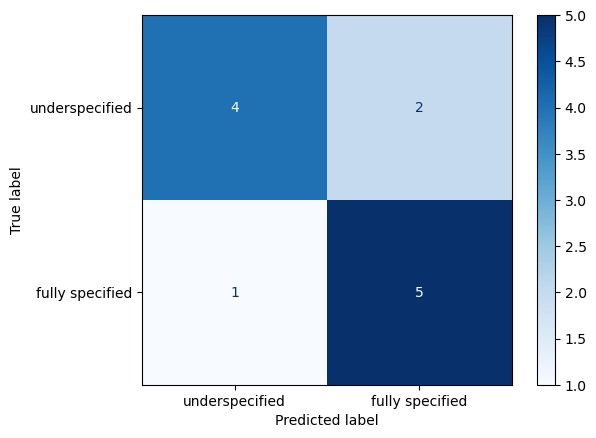

In [13]:
retrieve_results(test_df, "llama_3_3_70B_FS_UND_pilot")

## Implementation

In [6]:
test_prompts = prepare_test_prompts(df_test_1155, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 341 bytes (~85 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [7]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 231/231 [16:58<00:00,  4.41s/it]


,Unnamed: 0,request,gold_judgment,direct_source,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"{""query"": ""The idea that the united states was...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"{""query"": ""How many times french won the world...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"{""query"": ""When was pink floyd's dark side of ...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"{""query"": ""When did leonardo da vinci finish p...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"{""query"": ""Who is the first speaker of nationa...",fully specified
...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"{""query"": ""Is Pensacola sylvestris a multicell...",fully specified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"{""query"": ""What's the leaf mass per area of La...",fully specified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"{""query"": ""When did Patsyella make its last ap...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"{""query"": ""What's the body mass of Salamandra ...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.63      0.90      0.74       598
 underspecified       0.81      0.43      0.56       557

       accuracy                           0.68      1155
      macro avg       0.72      0.67      0.65      1155
   weighted avg       0.72      0.68      0.65      1155



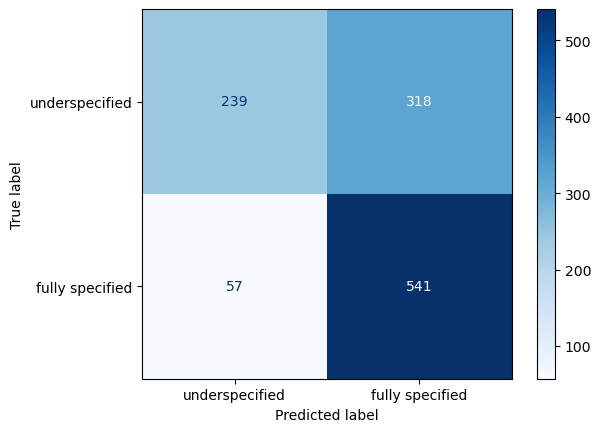

In [8]:
retrieve_results(test_df, "llama_3_3_70B_FS_UND")

                 precision    recall  f1-score   support

fully specified       0.65      0.90      0.76       431
 underspecified       0.84      0.52      0.64       424

       accuracy                           0.71       855
      macro avg       0.75      0.71      0.70       855
   weighted avg       0.75      0.71      0.70       855



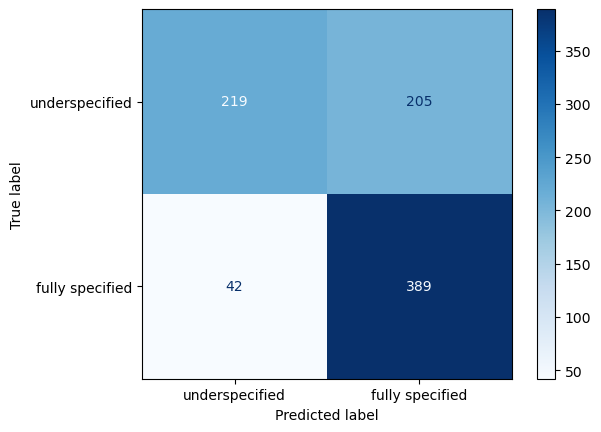

In [4]:
obtain_results_without("llama_3_3_70B_FS_UND.csv", 'AmbigQA')

In [ ]:
# If there are errors

result_df = pd.read_csv("llama_3_3_70B_FS_UND_corrected.csv")

print(classification_report(result_df["gold_judgment"], result_df['model_pred']))


judgment_gold = result_df['gold_judgment'].tolist()
judgment_model = result_df["model_pred"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap